In [1]:
using AutomotiveDrivingModels
using AutoViz
using Reactive
using Interact
using SplineUtils
using SplineRaceWay
using HierarchicalRecedingHorizonController
using NearestNeighbors

/Users/kyle/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# scene parameters
scene = Scene()
framerate = 24
Δt = 1.0/framerate # size of rendering timesteps
n_integration_sub_steps = 3 # sub steps for smoother integration
context = IntegratedContinuous(Δt, n_integration_sub_steps) # integrated continuous context

#car parameters
car_length = 4.8 # front wheel to back wheel
car_width = 2.5
v⁰  = 0.0 # initial velocity
δ⁰ = 0.0 # initical steering angle

############### INITIALIZE TRACK ################
lane_width = 30.0
radius = 45.0
edge_buffer = 0.25
T_MAX = lane_width/2.0 - car_width/2.0 - edge_buffer # max allowable projection distance from center of lane
base_speed= 0.0

# spline control points
Pts = 50*[0 -1 -2 -3 -3.5 -3 -2 -1 -0.5 -1 -2 -3 -4 -5 -6 -6.5 -6 -5.5 -6 -6 -5 -4 -3 -2 -1.5 -1 0 1 1.5 2 3 4 5 6.25 7 7 7 7 7 7 7 6 5 4 4 4 3 2 1 0; 
       0 0 0 0 -1 -2 -2 -2 -3 -4 -4 -4 -4 -4 -4 -3 -2 -1 0 1 2 3 4 4 3 2 2 2 3 4 4 4 4 4 3 2 1 0 -1 -2 -3 -4 -4 -3 -2 -1 0 0 0 0]
degree = 3 # degree of spline
num_points = 10001
num_samples = 420

track = Raceway(Pts,degree,num_points,num_samples,lane_width)
track;

In [3]:
carcolors = Dict{Int, Colorant}()

roadind1 = RoadIndex(CurveIndex(12,0),LaneTag(1,1))
vehstate1 = VehicleState(Frenet(roadind1, track.roadway), track.roadway, 0.0)
vehdef1 = VehicleDef(1,AgentClass.CAR, car_length, car_width)
push!(scene,Vehicle(vehstate1, vehdef1))
carcolors[1] = colorant"red"
track.models[1] = mapHRHC(1,track.roadway,context,h=12,v_max=120.0,μ=30.0,a_step=12.0,a_range=[-1,0,1],k=2)

roadind2 = RoadIndex(CurveIndex(4,0),LaneTag(1,1))
vehstate2 = VehicleState(Frenet(roadind2, track.roadway), track.roadway, 0.0)
vehdef2 = VehicleDef(2,AgentClass.CAR, car_length, car_width)
push!(scene,Vehicle(vehstate2, vehdef2))
carcolors[2] = colorant"blue"
track.models[2] = mapHRHC(2,track.roadway,context,h=12,v_max=125.0,μ=32.0,a_step=12.0,a_range=[-1,0,1],k=3)

roadind3 = RoadIndex(CurveIndex(14,0),LaneTag(1,1))
vehstate3 = VehicleState(Frenet(roadind3, track.roadway), track.roadway, 0.0)
vehdef3 = VehicleDef(3,AgentClass.CAR, car_length, car_width)
push!(scene,Vehicle(vehstate3, vehdef3))
carcolors[3] = colorant"yellow"
track.models[3] = mapHRHC(3,track.roadway,context,h=12,v_max=100.0,μ=25.0,a_step=12.0,a_range=[-1,0,1],k=3)

roadind4 = RoadIndex(CurveIndex(410,0),LaneTag(1,1))
vehstate4 = VehicleState(Frenet(roadind4, track.roadway), track.roadway, 0.0)
vehdef4 = VehicleDef(4,AgentClass.CAR, car_length, car_width)
push!(scene,Vehicle(vehstate4, vehdef4))
carcolors[4] = colorant"green"
track.models[4] = mapHRHC(4,track.roadway,context,h=12,v_max=125.0,μ=36.0,a_step=16.0,a_range=[-1,0,1],k=1)

actions = Array(DriveAction, length(scene))

track.obstacleMap = generateObstacleMap(scene, track.models)
track;

In [4]:
function drawsim(t, dt=NaN)
    k_level = 0 # needs to be updated into a loop
    for k_level in 0:maximum([model.k for (id,model) in track.models])
        for (i, veh) in enumerate(scene)
            model = track.models[veh.def.id]
            observe!(model, scene, track.roadway, veh.def.id, track.tree, track.obstacleMap, k_level)
            actions[i] = rand(model)
        end
    end
    for (veh, action) in zip(scene, actions)
        model = track.models[veh.def.id]
        context = action_context(model)
        veh.state = propagate(veh, action, context, track.roadway)
    end
#     render(scene, track.roadway, cam=FitToContentCamera(), car_colors=carcolors)
    targetid = 4
    zoom = 3.0
    render(scene, track.roadway, cam=CarFollowCamera(targetid, zoom), car_colors=carcolors, canvas_height=600)
#     render(scene, track.roadway, cam=SceneFollowCamera(zoom), car_colors=carcolors)
end

drawsim (generic function with 2 methods)

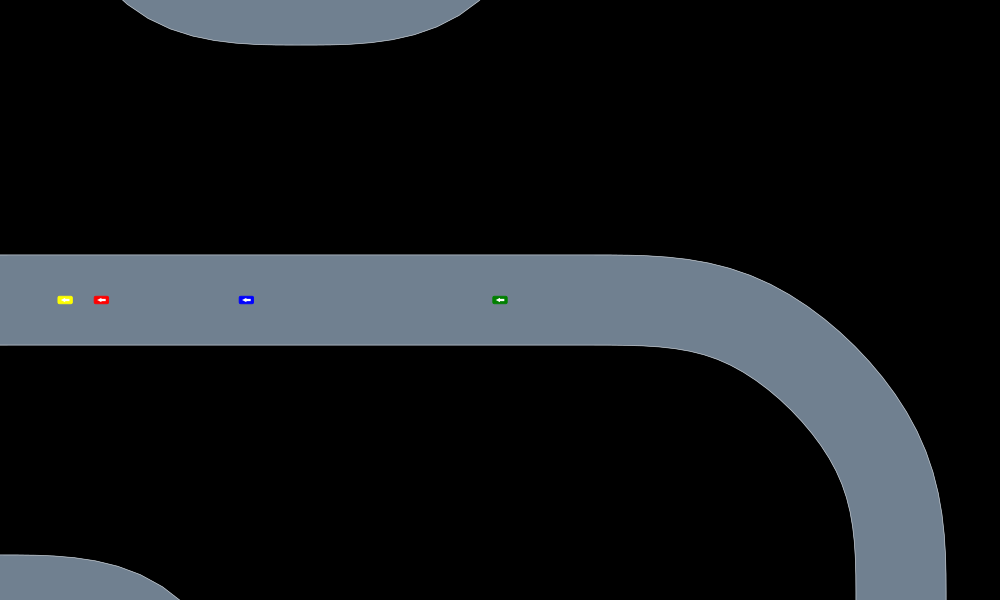

In [5]:
ticks = fps(framerate)
timestamps = map(_ -> time(), ticks)
map(drawsim, timestamps)

In [ ]:
# using Reel
# film = roll(drawsim, fps=framerate, duration=20)
# write("Level3Overtake.gif", film) # Write to a gif file